In [1]:
import yfinance as yahooFinance
import pandas as pd
import datetime

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
tf.random.set_seed(123)

startDate = datetime.datetime(2006, 2, 6) # modifying this from 1,1,06 to 2,6,06
endDate = datetime.datetime(2020, 12, 31)

vti = yahooFinance.Ticker("VTI").history(start=startDate,end=endDate).reset_index()
agg = yahooFinance.Ticker("AGG").history(start=startDate,end=endDate).reset_index()
dbc = yahooFinance.Ticker("DBC").history(start=startDate,end=endDate).reset_index()
vix = yahooFinance.Ticker("^VIX").history(start=startDate,end=endDate).reset_index()
 
all_assets = [vti, agg, dbc, vix]
labels = ["vti", "agg","dbc","vix"]

# look at dividends, capital gains

/Users/samuelmeisner/anaconda3/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
data = pd.DataFrame()
for i, asset in enumerate(all_assets):
    asset = asset.reset_index()
    lb = labels[i]
    data[lb] = asset['Close']

In [3]:
data_w_ret = pd.concat([ data.iloc[1:], data.pct_change().iloc[1:] ], axis=1)
data_w_ret.set_axis(labels + [l + "_ret" for l in labels], axis=1, inplace=True)
data_w_ret

/var/folders/tm/w_ghk37d14lgh4dy7_rf03240000gn/T/ipykernel_72168/4090425872.py:2: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  data_w_ret.set_axis(labels + [l + "_ret" for l in labels], axis=1, inplace=True)


,vti,agg,dbc,vix,vti_ret,agg_ret,dbc_ret,vix_ret
1,44.513222,57.665718,20.285255,13.590000,-0.009737,-0.000697,-0.028926,0.042178
2,44.833481,57.636864,20.198933,12.830000,0.007195,-0.000500,-0.004255,-0.055923
3,44.748070,57.671463,20.388838,13.120000,-0.001905,0.000600,0.009402,0.022603
4,44.840584,57.550526,20.017662,12.870000,0.002067,-0.002097,-0.018205,-0.019055
5,44.637772,57.590828,19.706909,13.350000,-0.004523,0.000700,-0.015524,0.037296
...,...,...,...,...,...,...,...,...
3747,183.378098,109.006447,13.794738,23.309999,0.001710,-0.000678,0.012517,-0.037969
3748,183.684860,109.108139,13.832635,21.530001,0.001673,0.000933,0.002747,-0.076362
3749,184.847015,109.126648,13.747366,21.700001,0.006327,0.000170,-0.006164,0.007896
3750,184.075439,109.145149,13.785263,23.080000,-0.004174,0.000170,0.002757,0.063594


In [4]:
cutoff = int(len(data) * 0.8)
train_data = data[:cutoff]
test_data = data[cutoff:]

In [5]:
data

,vti,agg,dbc,vix
0,44.950905,57.705963,20.889498,13.040000
1,44.513222,57.665718,20.285255,13.590000
2,44.833481,57.636864,20.198933,12.830000
3,44.748070,57.671463,20.388838,13.120000
4,44.840584,57.550526,20.017662,12.870000
...,...,...,...,...
3747,183.378098,109.006447,13.794738,23.309999
3748,183.684860,109.108139,13.832635,21.530001
3749,184.847015,109.126648,13.747366,21.700001
3750,184.075439,109.145149,13.785263,23.080000


In [6]:
def create_sequence(data, lookback):
    X = []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
    return X

In [7]:

class Model:
    def __init__(self):
        self.data = None
        self.model = None
        self.window_size = 50 #look at 50 random days at a time between updates
        
    def __build_model(self, input_shape, outputs):
        '''
        Builds and returns the Deep Neural Network that will compute the allocation ratios
        that optimize the Sharpe Ratio of the portfolio
        
        inputs: input_shape - tuple of the input shape, outputs - the number of assets
        returns: a Deep Neural Network model
        '''
        model = Sequential([
            LSTM(64, input_shape=input_shape),
            Flatten(),
            Dense(outputs, activation='softmax')
        ])
        
        # model = Sequential([
        # Flatten(),
        # Dense(self.window_size, activation='relu', input_shape=(self.window_size * outputs * 2,)),
        # Dense(12, activation='relu'),
        # Dense(outputs, activation='relu'),
        # tf.keras.layers.Softmax(axis=1)
        # ])

        def sharpe_loss(u, y_pred):
            print("yp", y_pred)
            print("u", u)
            
            #start_day = np.random.randint(0, len(self.data) - self.window_size) 
            #data = self.data[start_day:start_day + self.window_size] #addition: randomly sample
            
            # make all time-series start at 1
            data = tf.divide(self.data, self.data[0])  # was self.data for both

            # value of the portfolio after allocations applied
            portfolio_values = tf.reduce_sum(tf.multiply(data, y_pred), axis=1) 
            
            portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

            sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)
            
            # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
            #   we can negate Sharpe (the min of a negated function is its max)
            return -sharpe
        
        model.compile(loss=sharpe_loss, optimizer='adam')
        return model
    
    def get_allocations(self, data: pd.DataFrame, epochs=100):
        '''
        Computes and returns the allocation ratios that optimize the Sharpe over the given data
        
        input: data - DataFrame of historical closing prices of various assets
        
        return: the allocations ratios for each of the given assets
        '''
        
        # data with returns
        data_w_ret = np.concatenate([ data.values[1:], data.pct_change().values[1:] ], axis=1)
        
        data = data.iloc[1:]
        self.data = tf.cast(tf.constant(data), float)
        
        fit_predict_data = data_w_ret[np.newaxis,:]    
        # Create sequences with the lookback window
        #X = create_sequence(fit_predict_data[0], self.window_size)
        #print(X.shape)
        #X = X[np.newaxis,:]
        
        if self.model is None:
            self.model = self.__build_model(data_w_ret.shape, len(data.columns)) # maybe change 1st argument
            #self.model = self.__build_model(_, len(data.columns)) 
            
        
        
        self.model.fit(fit_predict_data, np.zeros((1, len(data.columns))), epochs=epochs, shuffle=False)#,verbose=0) # to make it not print
        return self.model.predict(fit_predict_data)[0]
    
    def predict_weights(self, data):
        return self.model.predict(data)[0]

In [8]:
model = Model()

In [9]:
coeffs = model.get_allocations(train_data, epochs = 5)

Epoch 1/5
yp Tensor("sequential/dense/Softmax:0", shape=(None, 4), dtype=float32)
u Tensor("IteratorGetNext:1", shape=(None, 4), dtype=float32)
yp Tensor("sequential/dense/Softmax:0", shape=(None, 4), dtype=float32)
u Tensor("IteratorGetNext:1", shape=(None, 4), dtype=float32)
1/1 [==============================] - 1s 748ms/step - loss: -0.0179
Epoch 2/5
1/1 [==============================] - 0s 194ms/step - loss: -0.0183
Epoch 3/5
1/1 [==============================] - 0s 188ms/step - loss: -0.0187
Epoch 4/5
1/1 [==============================] - 0s 188ms/step - loss: -0.0241
Epoch 5/5
1/1 [==============================] - 0s 153ms/step


In [10]:
coeffs

array([0.5641341 , 0.19026695, 0.08204304, 0.16355585], dtype=float32)

In [11]:
test_data_w_ret = np.concatenate([ test_data.values[1:], test_data.pct_change().values[1:] ], axis=1)
test_data = test_data.iloc[1:]
fpd_test = test_data_w_ret[np.newaxis,:]
res = model.model.predict(fpd_test)

print(res)

1/1 [==============================] - 0s 114ms/step
[[0.5277492  0.22588441 0.08440995 0.1619564 ]]


Notes: 
- fit_predict data needs to be same dimension as in other attempt (below).
- new function for test needs to be made on separate test data.
- train, get allocations separate functions.

## Below here is Sam's first attempt (failed to converge):

for i, asset in enumerate(all_assets):
    asset = asset.reset_index()
    asset['Returns'] = (asset['Close']-asset['Open'])/asset['Open']
    asset['Date'] = asset['Date'].dt.date
    all_assets[i] = asset

returns = pd.DataFrame()
returns['Date'] = all_assets[0]['Date']
for i, l in enumerate(labels):
    returns[l] = all_assets[i]['Close']
    returns[l + '_return'] = all_assets[i]['Returns']

In [12]:
returns = data_w_ret
returns

,vti,agg,dbc,vix,vti_ret,agg_ret,dbc_ret,vix_ret
1,44.513222,57.665718,20.285255,13.590000,-0.009737,-0.000697,-0.028926,0.042178
2,44.833481,57.636864,20.198933,12.830000,0.007195,-0.000500,-0.004255,-0.055923
3,44.748070,57.671463,20.388838,13.120000,-0.001905,0.000600,0.009402,0.022603
4,44.840584,57.550526,20.017662,12.870000,0.002067,-0.002097,-0.018205,-0.019055
5,44.637772,57.590828,19.706909,13.350000,-0.004523,0.000700,-0.015524,0.037296
...,...,...,...,...,...,...,...,...
3747,183.378098,109.006447,13.794738,23.309999,0.001710,-0.000678,0.012517,-0.037969
3748,183.684860,109.108139,13.832635,21.530001,0.001673,0.000933,0.002747,-0.076362
3749,184.847015,109.126648,13.747366,21.700001,0.006327,0.000170,-0.006164,0.007896
3750,184.075439,109.145149,13.785263,23.080000,-0.004174,0.000170,0.002757,0.063594


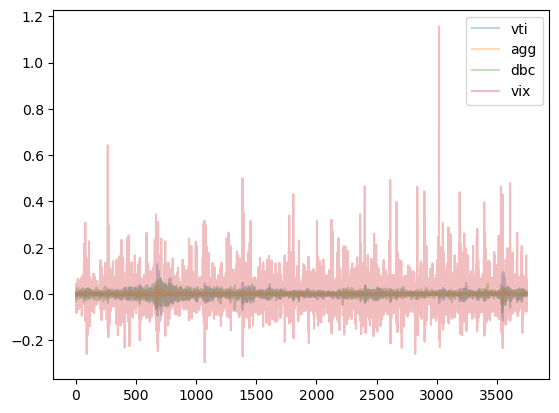

In [13]:
import matplotlib.pyplot as plt
plt.plot(returns['vti_ret'],label="vti", alpha=0.3)
plt.plot(returns['agg_ret'],label="agg", alpha=0.3)
plt.plot(returns['dbc_ret'],label="dbc", alpha=0.3)
plt.plot(returns['vix_ret'],label="vix", alpha=0.3)
plt.legend()
plt.show()

### Intuitively, the model should learn to avoid vix.

In [14]:
window = 50  

# Function to create sequence with lookback
def create_sequence(data, lookback):
    X = []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
    return np.array(X)

# Create sequences with the lookback window
# X = create_sequence(returns.drop(columns=["Date"]), window)
X = create_sequence(returns, window)

# Splitting data into training and testing sets
train_size = int(len(X) * 0.8)  # 80% for training
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]

In [51]:
X_train.shape

torch.Size([2960, 50, 8])

In [16]:
X_train = torch.tensor(X_train)

In [17]:
def sharpe_ratio(returns_data):
    mn = returns_data.mean()
    denom = torch.sqrt( (returns_data**2).mean() - (returns_data.mean()**2 ))
    loss = -mn / denom
    loss.requires_grad=True
    return loss

def sharpe_loss(data, y_pred):
    # make all time-series start at 1
    data = torch.divide(data, data[0])  

    # value of the portfolio after allocations applied
    portfolio_values = tf.reduce_sum(torch.multiply(data, y_pred), axis=1) 

    portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

    sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)

    # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
    #   we can negate Sharpe (the min of a negated function is its max)
    return -sharpe

In [44]:
def port_returns(weights, data, i):
    returns = data[i+1,:][0]
    returns = returns[[4,5,6,7]]#torch.tensor([returns[i] for i in [1,3,5,7]],dtype=torch.float64)
    result = weights@returns.float()
    return result#weights.clone().detach().float()@returns.clone().detach().float()
    #return torch.tensor(weights,dtype=torch.float64)@(torch.tensor(returns,dtype=torch.float64))#.detatch().numpy())

In [45]:
n_assets = 4
window = 50
model = nn.Sequential(
    nn.Flatten(0),
    nn.Linear(int(window * n_assets * 2), window),
    nn.ReLU(),
    nn.Linear(window,12),
    nn.ReLU(),
    nn.Linear(12,4),
    nn.Softmax(0)
)

learning_rate = .001;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

X_train = np.array(create_sequence(train_data.values, 50))
X_train = np.concatenate([ X_train[1:], tf.convert_to_tensor(X_train).pct_change()[1:] ], axis=1)
X_train = torch.tensor(X_train)

In [83]:
epochs = 100
batch_size = 64
losses = []
test_losses = []
go = True
t = 0

while t < epochs:
    batch_returns = []
    for _ in range(batch_size):#len(X_train)-1):
        i = np.random.randint(0, X_train.shape[0]-1)
        batch = X_train[i].float()#.flatten().float()
        weights = model(batch)
        this_return = port_returns(weights, X_train, i)
        # loss = sharpe_loss(batch, weights)
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()
        batch_returns.append(this_return)
    batch_returns = torch.tensor(batch_returns,dtype=torch.float64)
    loss = sharpe_ratio(batch_returns)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # test_preds = model(X_test)
    # test_losses.append(sharpe_ratio(test_preds))
    if t % 10== 0: 
        print(f"Epoch {t+1}")
        print(f"loss={loss.item():.3f}")
    t += 1

Epoch 1
loss=0.001
Epoch 11
loss=-0.131
Epoch 21
loss=-0.156
Epoch 31
loss=-0.016
Epoch 41
loss=-0.204
Epoch 51
loss=0.109
Epoch 61
loss=0.006
Epoch 71
loss=-0.213
Epoch 81
loss=0.113
Epoch 91
loss=-0.146


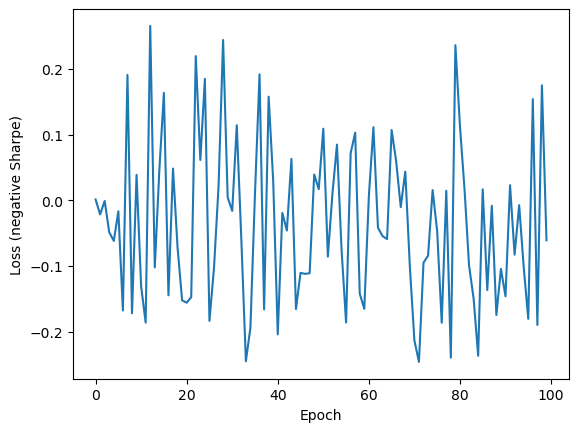

In [84]:
plt.plot(range(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss (negative Sharpe)")
plt.show()

Alternative to ask George if we can't debug this version: 
- Method found on github trains on whole dataset at once to predict next day's portfolio weights. This requires daily retraining. We don't think that's what the paper suggests or what we suggested with you, is that correct? Is this a suitable alternative (may be easier for us to implement) or is that a q for the professor?
- Alternatively, how can we adjust the code we found on github to be what the paper suggests?